# Bankloan default classifier

This classifier uses a weak learner boosted classifier and random forest classifier to predict whether a bank customer defaulted on their loan or not.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from IPython.display import Image
import pandas as pd
from functools import reduce
from xgboost import XGBClassifier
import gdown

import pydotplus
from tqdm import tqdm

# Plot inline
%matplotlib inline

In [19]:
#Define the classifier
bankloan_rf = RandomForestClassifier(n_estimators=1000, 
                       criterion='gini', 
                       max_depth=None,
                       min_samples_split=2, 
                       min_samples_leaf=0.001, 
                       min_weight_fraction_leaf=0.0, 
                       max_features='auto', 
                       max_leaf_nodes=None,
                       min_impurity_decrease=0.0001,
                       bootstrap=True, 
                       oob_score=True,  
                       n_jobs=-1, 
                       random_state=20190305, # Seed
                       verbose=1, 
                       warm_start=False, 
                       class_weight='balanced'
                                    )

In [3]:
# Import the dataset from a shared Google Drive link 
url = 'https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs'
output = 'BankloanClean.pkl'
gdown.download(url, output, quiet = False)

# Read from the file we just got.
bankloan_data = pd.read_pickle('BankloanClean.pkl')

# Drop a categorical variable
bankloan_data.drop('Education', inplace = True, axis = 1)

Downloading...
From: https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs
To: C:\Users\avand\OneDrive\Desktop\udemy data science\BankloanClean.pkl
100%|████████████████████████████████████████████████████████████████████████████████| 135k/135k [00:00<00:00, 676kB/s]


In [4]:
bankloan_data.describe()

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000
mean,257649.480188,34.003358,6.799866,6.233714,56.898590,9.904835,1.801370,3.664231,0.366850,0.361988
std,139646.983244,12.982437,8.765093,5.987928,55.062182,6.649132,2.340326,4.665854,0.294387,0.480737
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98410.000000,24.000000,0.000000,2.000000,27.000000,4.800000,0.420000,1.100000,0.150000,0.000000
50%,316013.000000,31.000000,4.000000,5.000000,39.000000,8.500000,0.980000,2.200000,0.290000,0.000000
75%,370695.000000,41.000000,10.000000,9.000000,63.000000,13.500000,2.170000,4.500000,0.500000,1.000000
max,453777.000000,79.000000,63.000000,34.000000,533.000000,40.700000,19.050000,52.650000,2.150000,1.000000


In [5]:
# Split into train and test, fixing seed.
bankloan_train_noWoE, bankloan_test_noWoE = train_test_split(bankloan_data.iloc[:, 1:], # Data 
                                                             test_size = 0.3,           # Size of test
                                                             random_state = 20201107)   # Seed

# Train the RF.
bankloan_rf.fit(bankloan_train_noWoE.iloc[:,:-1], 
               bankloan_train_noWoE['Default'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.0s finished


RandomForestClassifier(class_weight='balanced', min_impurity_decrease=0.0001,
                       min_samples_leaf=0.001, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=20190305, verbose=1)

In [6]:
# Apply the model to the test set.
rf_pred_class_test = bankloan_rf.predict(bankloan_test_noWoE.iloc[:, :-1])
rf_probs_test = bankloan_rf.predict_proba(bankloan_test_noWoE.iloc[:, :-1])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


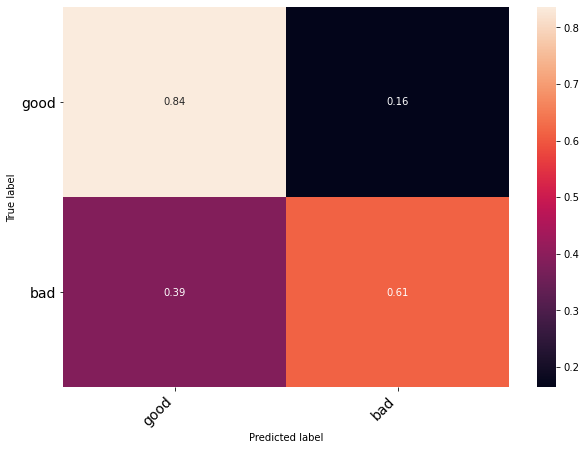

In [7]:
# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = bankloan_test_noWoE['Default'], 
                    y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

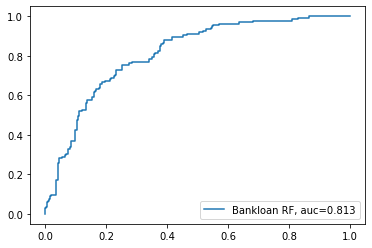

In [8]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], rf_probs_test[:,1])


auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

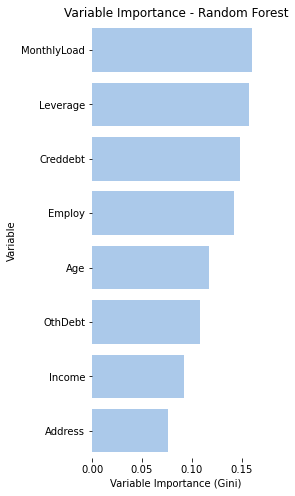

In [9]:
# Plot variable importance
importances = bankloan_rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

In [10]:
#Define the classifier.
XGB_Bankloan = XGBClassifier(max_depth=3,                 
                            learning_rate=0.1,            
                            n_estimators=100,             
                            verbosity=1,                  
                            objective='binary:logistic',  
                            booster='gbtree',             
                            n_jobs=2,                     
                            gamma=0.001,                   
                            subsample=1,                  
                            colsample_bytree=1,           
                            colsample_bylevel=1,          
                            colsample_bynode=1,           
                            reg_alpha=1,                  
                            reg_lambda=0,                 
                            scale_pos_weight=1,           
                            base_score=0.5,               
                            random_state=20201107,        
                            missing=None                  
                            )

In [11]:
# Define the parameters
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3],
                 'learning_rate' : [0.001, 0.01, 0.1]
                  })


val_train = bankloan_train_noWoE.sample(frac = 0.3,random_state = 20201107)

In [12]:
# Define grid search object.
GridXGB = GridSearchCV(XGB_Bankloan,         
                       param_grid,          
                       cv = 3,               
                       scoring = 'roc_auc', 
                       n_jobs = -1,         
                       refit = False,       
                       verbose = 1          
                      )

In [13]:
# Train grid search.
GridXGB.fit(val_train.iloc[:, :-1], val_train['Default'])

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(gamma=0.001, n_jobs=2,
                                     random_state=20201107, reg_alpha=1,
                                     reg_lambda=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 3], 'n_estimators': [50, 100, 150]},
             refit=False, scoring='roc_auc', verbose=1)

In [14]:
# Create XGB with best parameters.
XGB_Bankloan = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), 
                            learning_rate=GridXGB.best_params_.get('learning_rate'), 
                            n_estimators=GridXGB.best_params_.get('n_estimators'), 
                            verbosity=1,                  
                            objective='binary:logistic',  
                            booster='gbtree',             
                            n_jobs=2,                     
                            gamma=0.001,                  
                            subsample=1,                  
                            colsample_bytree=1,           
                            colsample_bylevel=1,          
                            colsample_bynode=1,           
                            reg_alpha=1,                  
                            reg_lambda=0,                 
                            scale_pos_weight=1,           
                            base_score=0.5,               
                            random_state=20201107,        
                            missing=None                 
                            )

In [15]:
# Train over all training data.
XGB_Bankloan.fit(bankloan_train_noWoE.iloc[:, :-1], bankloan_train_noWoE['Default'])

XGBClassifier(gamma=0.001, n_jobs=2, random_state=20201107, reg_alpha=1,
              reg_lambda=0)

[0.2918725  0.19474274 0.14345832 0.12008458 0.09886264 0.06032611
 0.04905848 0.04159461]
['MonthlyLoad', 'Employ', 'Creddebt', 'Leverage', 'Age', 'Address', 'OthDebt', 'Income']


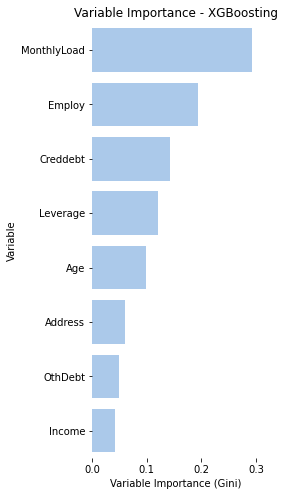

In [16]:
# Plot variable importance
importances = XGB_Bankloan.feature_importances_
indices = np.argsort(importances)[::-1] 
print(importances[indices])
y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices]
print(y)
f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

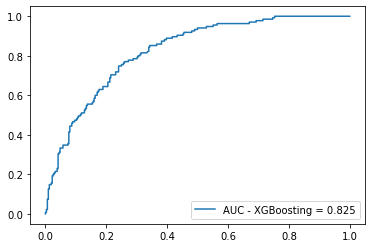

In [17]:
# Calculate probability
probTest = XGB_Bankloan.predict_proba(bankloan_test_noWoE.iloc[:, :-1])
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], 
                                 probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = probTest),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()